<a href="https://colab.research.google.com/github/umerkay/deeplearning-notebooks/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
import torch.nn as nn
import torch.nn.functional as F

In [37]:
def show_example(dataset, index):
    img, label = dataset[index]
    print('Label: ', dataset.dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

batch_size = 128

#import cifar10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

val_size = 5000
train_size = len(trainset) - val_size

trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size, num_workers=4, pin_memory=True)

print("Train, Val, Test:")
print((len(trainset), len(valset), len(testset)))

100%|██████████| 170498071/170498071 [00:01<00:00, 91724727.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train, Val, Test:
(45000, 5000, 10000)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Label:  automobile (1)


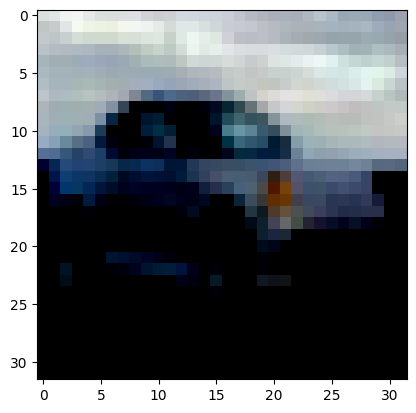

In [4]:
show_example(trainset, 1215)

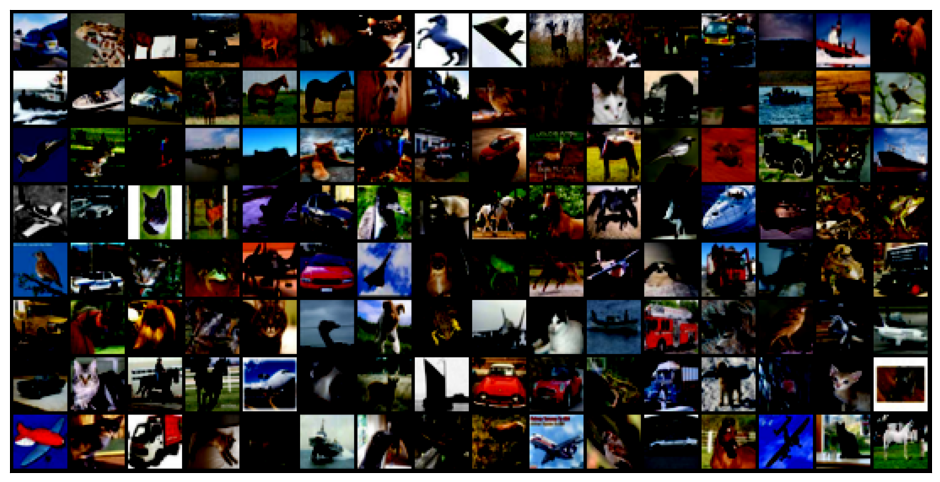

In [5]:
show_batch(trainloader)

In [6]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [41]:
class Classifier(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    # define a sequential model with 3 conv layers and 2 linear layers and a softmax layer, include dropout and batchnorm
    self.network = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),  # Batch normalization
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),  # Batch normalization
        nn.ReLU(),
        nn.MaxPool2d(2, 2),  # output: 64 x 16 x 16

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),  # Batch normalization
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),  # Batch normalization
        nn.ReLU(),
        nn.MaxPool2d(2, 2),  # output: 128 x 8 x 8

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),  # Batch normalization
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),  # Batch normalization
        nn.ReLU(),
        nn.MaxPool2d(2, 2),  # output: 256 x 4 x 4

        nn.Flatten(),
        nn.Linear(256 * 4 * 4, 1024),
        nn.BatchNorm1d(1024),  # Batch normalization
        nn.ReLU(),
        nn.Dropout(0.5),  # Dropout layer
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),  # Batch normalization
        nn.ReLU(),
        nn.Dropout(0.5),  # Dropout layer
        nn.Linear(512, 10))


  def forward(self, xb):
      return self.network(xb)

In [30]:
device = get_default_device()
trainloader = DeviceDataLoader(trainloader, device)
valloader = DeviceDataLoader(valloader, device)

In [42]:
model = Classifier()
to_device(model, device);
model

Classifier(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [43]:
evaluate(model, valloader)

{'val_loss': 2.3032124042510986, 'val_acc': 0.09726562350988388}

In [33]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [44]:
history = fit(num_epochs, lr, model, trainloader, valloader, opt_func)

Epoch [0], train_loss: 1.1895, val_loss: 0.8939, val_acc: 0.6750
Epoch [1], train_loss: 0.7483, val_loss: 0.8968, val_acc: 0.6902
Epoch [2], train_loss: 0.5862, val_loss: 0.5795, val_acc: 0.7982
Epoch [3], train_loss: 0.4686, val_loss: 0.6860, val_acc: 0.7590
Epoch [4], train_loss: 0.3820, val_loss: 0.5330, val_acc: 0.8152
Epoch [5], train_loss: 0.3031, val_loss: 0.5210, val_acc: 0.8227
Epoch [6], train_loss: 0.2435, val_loss: 0.6242, val_acc: 0.8080
Epoch [7], train_loss: 0.1890, val_loss: 0.5127, val_acc: 0.8344
Epoch [8], train_loss: 0.1572, val_loss: 0.5918, val_acc: 0.8262
Epoch [9], train_loss: 0.1203, val_loss: 0.6084, val_acc: 0.8350


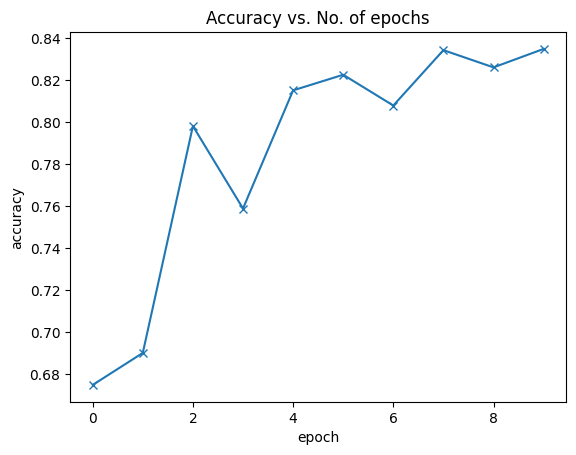

In [45]:
plot_accuracies(history)

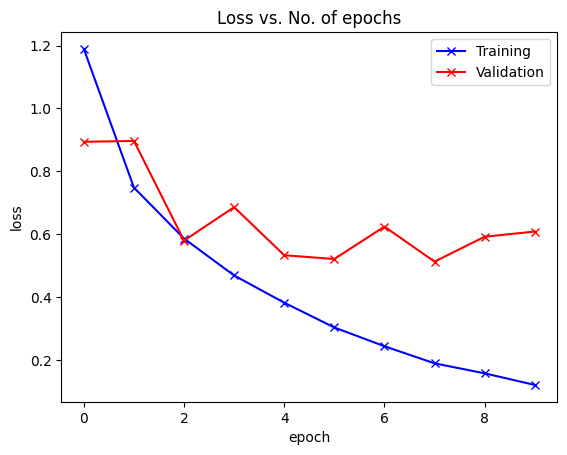

In [46]:
plot_losses(history)


In [55]:
testloader = DeviceDataLoader(testloader, device)

In [57]:
print("Test set", evaluate(model, testloader))
print("Train set", evaluate(model, trainloader))
print("Val set", evaluate(model, valloader))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test set {'val_loss': 0.6152548789978027, 'val_acc': 0.8346518874168396}
Train set {'val_loss': 0.07720185071229935, 'val_acc': 0.9742345213890076}
Val set {'val_loss': 0.6084123849868774, 'val_acc': 0.8349609375}
